<a href="https://colab.research.google.com/github/willhoff2/cs449w23/blob/main/project-bucket/proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 449 Final Project Proposal

Due: February 1, 2023 at 11:59pm

## 1. Names and Net IDs

Griffin Minster: ghm5690\
Jiayan Luo: jle8360\
Gabe Bider: glb0128\
Will Hoffmann: wjh8263

## 2. Abstract

*Your abstract should be two or three sentences describing the motivation
for your project and your proposed methods. For example:*

We plan on testing a variety of deep learning models such as CNNs and other neural net architectures to analyze satellite data. We want to be able to identify extreme weather events, measure the amount of foresty burned in wildfires, and/or detect deforestation.

## 3. Introduction

*Why is this project interesting to you? Describe the motivation for pursuing this project. Give a specific description of your data and what machine learning task you will focus on. For example:*

We think it would be both interesting and beneficial to use deep learning technologies to classify prevalent issues in today's world such as the effects of forest fires and deforestation. A greater knowledge of these issues could allow for greater detection and prevention in the deepest affected areas.

## 4a. Describe your dataset(s)

*List the datasets you plan to use, where you found them, and what they contain. Be detailed! For each dataset, what does the data look like? What is the data representation? (e.g., what resolution of images? what length of sequences?) How is the data annotated or labeled? Include citations for the datasets. Include at least one citation of previous work that has used your data, or explain why no one has used your data before. For example:*

We use the popular MNIST dataset, which contains 70,000 different 28x28 pixel greyscale images of handwritten digits. The dataset was created by the American Census Bureau in 1998 ...

1. We use the Sentinel dataset from Google Earth Engine. The Sentinel dataset is a near realtime 10m resolutoin global land use land cover dataset. Over 5,000 dynamic world images are produced everyday based on the Sentinel-2 Top of Amotspohere architecture. Each pixel in the image is labeled with probabilities of the degree of tree cover, how built up a particular area is, or snow coverage if there's been a recent snowstorm. Google has used this dataset to measure climate and land changes. 

  References: 
  
  https://dynamicworld.app/about

  https://cloud.google.com/blog/topics/developers-practitioners/measuring-climate-and-land-changes-ai


2. We use the EuroSAT land use and land cover dataset which is a dataset and benchmark for land use and land cover classification. The dataset is based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of 10 classes. 27,000 images are labeled and georeferenced in the dataset. This dataset was released in 2017 by Helber et. al and has been referenced in several papers since including Helber et. al.

  References: 
  
  https://paperswithcode.com/paper/eurosat-a-novel-dataset-and-deep-learning

In [ ]:
import ee
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Trigger authentication
ee.Authenticate()

# Initialize the library
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=VZqUiYfPvr8P3TdshgBOCMZnHBwzkU3vST0W379uknA&tc=CzCH1fNGR8EZ97KzFI5_2JlQlYtzjgMliS-KOuOcobg&cc=fs5MRpxdtC34AfTNKsR9uGNz2BbEl6oOqzfHmZfZojw

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh7PbX2N-6RULbDv5RNwAZqrXHrB-EzYvCpbh9rNqLbbR6lLOCIP7yw

Successfully saved authorization token.


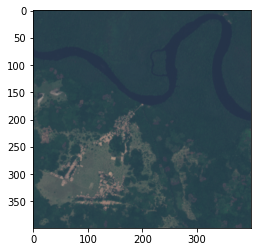

In [ ]:
# Display model
# This is Sentinel-2 L1C.
s2 = ee.ImageCollection('COPERNICUS/S2')

# In this example, we'll define a point in the DRC.
POI = ee.Geometry.Point([21.0503961, -3.4844154])

# Filter the collection to mid-October 2021 intersecting the Point Of Interest.
s2 = s2.filterBounds(POI).filterDate('2021-10-05', '2021-10-11')

# Grab the first image in the filtered collection. Dynamic World uses a subset
# of Sentinel-2 bands, so we'll want to select down to just those.
s2_image = s2.first()
s2_image = s2_image.select('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11',
                           'B12')

# Resample the data so that the bands all map 1 pixel -> 10m. We'll use B2 (red)
# for a reference projection.
s2_image = s2_image.toFloat().resample('bilinear').reproject(
    s2_image.select('B2').projection());

# Squash the image bands down into an array-per-pixel, and sample out a square
# from our image centered on the POI. In this example, we'll go out 2km in each
# direction.
#
# This creates an ee.Feature with a property named "array" that we'll grab
# later.
s2_image_sample = s2_image.toArray().sampleRectangle(POI.buffer(2000))

image = np.array(s2_image_sample.getInfo()['properties']['array'])

plt.imshow(image[:, :, [2, 1, 0]] / 3000)

plt.show()

In [10]:
# !wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
# !unzip -q EuroSAT.zip -d 'EuroSAT/'
# !rm EuroSAT.zip
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username": "willhoffmann", "key": "0d15b8b91007a6f053ad79ef52071f92"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token,file)

#!export KAGGLE_USERNAME= willhoffmann
#!export KAGGLE_KEY= 0d15b8b91007a6f053ad79ef52071f92



mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 9.36G/9.37G [01:08<00:00, 160MB/s]
100% 9.37G/9.37G [01:08<00:00, 147MB/s]


In [16]:
!kaggle competitions download -c deforestation
!unzip -q deforestation.zip -d 'data/'
!rm deforestation.zip
print("Done :D")

deforestation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import torch
from torch.utils import data

class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations 
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

In [ ]:

import torchvision
from torchvision import datasets, models, transforms
# Load the dataset
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


Train/test sizes: 21600/5400


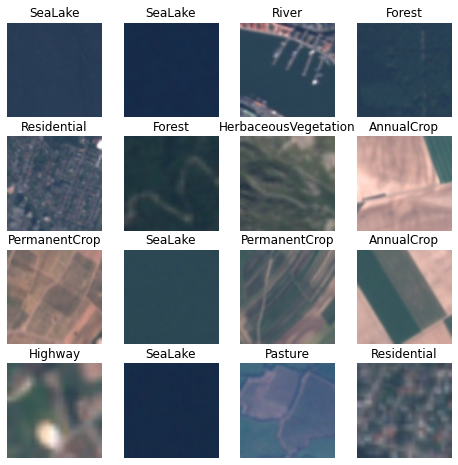

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# Apply different transformations to the training and test sets
train_data = EuroSAT(dataset, train_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 80% train / 20% test 
# by subsetting the transformed train and test datasets
train_size = 0.8
indices = list(range(int(len(dataset))))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:split])
test_data = data.Subset(test_data, indices=indices[split:])
print("Train/test sizes: {}/{}".format(len(train_data), len(test_data)))

num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

# visualize
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8,8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
   
    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

## 5. Methods

We plan to try out CNN and RNN models. The CNN was created between 1989-1998 and has had a lot of use in regards to image classification. Specifically to our task of satellite image classification, there is papers done by Pritt and Chern, Mahmon and Ya'acob, and Wang, Zheng, Wang, Shen and Huang. The RNN was created between 1982-1993. RNNs and their variants are usually used for time series modeling; however, there has been literature exploring the use of RNN models for similar tasks (Maggiori, Charpia, Tarabalka, and Alliez). We will train our model using Cross-Entropy loss, because this is a classification model -- classifying betwen whether an image shows a forest fire or deforestation -- and this is the standard loss function for this type of problem. It's not flashy, but we know it will get the job done effectively. We will set aside some data for testing and evaluate its performance on this held out set of data with accuracy and recall in order to get a capture of its general performance as well as its ability to even detect the two events of interest. We may expand to roc-auc or f1-score for a more completely picture but will consider this more when we get to training our models.  

## 6. Deliverables

*Include at least six goals that you think you should be able to achieve over the course of the quarter. These should be nontrivial, but you should have at least one and hopefully both of your "Essential" goals done by the project update, due February 24. Your "Stretch" goals should be ambitious enough such that completing one is doable, but completing both this quarter is unlikely.*

### 6.1 Essential Goals
- Use a CNN/RNN to classify weather events (hurricane, wildfire, etc.)
- Detect deforestation (real time)

### 6.2 Desired Goals
- Discuss model performance while focusing on model metrics 
- Detect less major weather events such as small rain or snow storms across the country

### 6.3 Stretch Goals
- Detect illegal versus legal deforestation
- Detect changes in landscape over time

## 7. Hopes and Concerns

We are excited to solve a real world problem; however, we are worried about getting access to the data and having enough on hand, for both fires and deforestation, to be able to effectively create a powerful model to help solve the model.

## 8. References

Pelletier C, Webb GI, Petitjean F. Temporal Convolutional Neural Network for the Classification of Satellite Image Time Series. Remote Sensing. 2019; 11(5):523. https://doi.org/10.3390/rs11050523

M. Pritt and G. Chern, "Satellite Image Classification with Deep Learning," 2017 IEEE Applied Imagery Pattern Recognition Workshop (AIPR), Washington, DC, USA, 2017, pp. 1-7, doi: 10.1109/AIPR.2017.8457969.

E. Maggiori, G. Charpiat, Y. Tarabalka and P. Alliez, "Recurrent Neural Networks to Correct Satellite Image Classification Maps," in IEEE Transactions on Geoscience and Remote Sensing, vol. 55, no. 9, pp. 4962-4971, Sept. 2017, doi: 10.1109/TGRS.2017.2697453.

N. A. Mahmon and N. Ya'acob, "A review on classification of satellite image using Artificial Neural Network (ANN)," 2014 IEEE 5th Control and System Graduate Research Colloquium, Shah Alam, Malaysia, 2014, pp. 153-157, doi: 10.1109/ICSGRC.2014.6908713.

J. Wang, Y. Zheng, M. Wang, Q. Shen and J. Huang, "Object-Scale Adaptive Convolutional Neural Networks for High-Spatial Resolution Remote Sensing Image Classification," in IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, vol. 14, pp. 283-299, 2021, doi: 10.1109/JSTARS.2020.3041859.